## Fine Tune Language Model



#### The results of the above query can be downloaded as a csv file from this link: 

https://storage.googleapis.com/issue_label_bot/k8s_issues/000000000000.csv

In [1]:
import os
import torch
from torch.cuda import empty_cache
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import pandas as pd
import numpy as np
import re
pd.set_option('max_colwidth', 1000)

In [2]:
df = pd.read_csv('https://storage.googleapis.com/issue_label_bot/k8s_issues/000000000000.csv')
df.labels = df.labels.apply(lambda x: eval(x))
#remove target leakage from kubernetes which are the bot commands
df['body'] = df.body.apply(lambda x: re.sub('(/sig|/kind|/status/triage/|priority) \S+', '', str(x)))
df['last_time'] = pd.to_datetime(df.last_time)

### Filter Labels By YAML File


In [3]:
import base64
import requests
import yaml

def get_current_labels(url="https://raw.githubusercontent.com/kubernetes/test-infra/master/label_sync/labels.yaml"):
    """
    Get list of valid issue labels (b/c labels get deprecated over time).
    See: https://kubernetes.slack.com/archives/C1TU9EB9S/p1561570627363100
    """
    req = requests.get(url)
    yml = yaml.safe_load(req.content)
    return [x['name'] for x in yml['default']['labels']]

In [4]:
current_labels = get_current_labels()
# remove deprecated labels
df.labels = df.labels.apply(lambda x: [l for l in x if l in current_labels])
# filter out issues without any labels
df = df[df.labels.apply(lambda x: x != [])]
print(f'Number of labeled issues after filtering: {df.shape[0]:,}')

Number of labeled issues after filtering: 19,564


In [5]:
df.head(1)

,updated_at,last_time,labels,repo,url,title,body,len_labels
0,2018-02-24 15:09:51 UTC,2018-02-24 15:09:51+00:00,"[lifecycle/rotten, priority/backlog, sig/cluster-lifecycle, sig/node]",kubernetes/kubernetes,"""https://api.github.com/repos/kubernetes/kubernetes/issues/16512""",minions ip does not follow --hostname-override when set to a hostname,"according to 9267, the kubelet should register a node with the --hostname-override cluster from scratch . this does not work if set to an actual hostname even one that resolves correctly . working with the ip: sh $ /opt/bin/kubelet --hostname-override=172.16.25.131 --address=172.16.25.131 ... $ kubectl describe node minion-2 name: minion-2 ... addresses: 172.16.25.131 and when the override is set to a hostname which resolves to the 172 ip : $ /opt/bin/kubelet --hostname-override=my-server.com --address=172.16.25.131 ... $ kubectl describe node minion-2 name: minion-2 ... addresses: 2a01:4f8:110:4085::2",4


# Explore The Data

### Count Labels

### Filter Issues Again To Remove Those w/o Labels occuring at least 50 times

In [6]:
from collections import Counter
c = Counter()

for row in df.labels:
    c.update(row)

In [7]:
min_threshold = 50
min_threshold_labels = [k for k in c if c[k] >= min_threshold]

print(f'{len(min_threshold_labels)} labels that occur at least {min_threshold} times.')

44 labels that occur at least 50 times.


In [8]:
df['labels'] = df.labels.apply(lambda x: [l for l in x if l in min_threshold_labels])
df = df[df.labels.apply(lambda x: x != [])]
print(f'Number of labeled issues after filtering again: {df.shape[0]:,}')

Number of labeled issues after filtering again: 19,549


Remaining Issues

In [9]:
for l in min_threshold_labels:
    print(f'{l}: {c[l]}')

lifecycle/rotten: 4352
priority/backlog: 1588
sig/cluster-lifecycle: 950
sig/node: 2738
kind/flake: 3294
lifecycle/stale: 784
help wanted: 132
kind/feature: 2051
sig/api-machinery: 2228
sig/scalability: 511
sig/cli: 1109
kind/bug: 6107
needs-sig: 1188
sig/autoscaling: 210
sig/network: 1829
sig/cloud-provider: 54
kind/failing-test: 294
priority/important-longterm: 166
sig/storage: 1596
sig/scheduling: 798
sig/apps: 844
priority/awaiting-more-evidence: 383
priority/important-soon: 1222
priority/critical-urgent: 553
sig/windows: 185
kind/documentation: 483
sig/auth: 600
triage/support: 288
sig/docs: 205
sig/testing: 715
sig/gcp: 203
sig/release: 330
kind/cleanup: 438
lifecycle/frozen: 131
sig/azure: 302
sig/aws: 438
sig/multicluster: 175
sig/instrumentation: 253
sig/openstack: 151
kind/design: 130
kind/api-change: 57
sig/contributor-experience: 152
sig/architecture: 99
triage/unresolved: 147


### Number of Issues By Time (after filtering)

(Issues were filtered out in previous years due to having deprecated issue labels)

In [10]:
df['year'] = df.last_time.apply(lambda x: x.year)
df.groupby('year')['body'].count()

year
2016    2714
2017    6311
2018    7238
2019    3286
Name: body, dtype: int64

#### Sig/ Labels

## Parse Issue Bodies

In [11]:
from inference import InferenceWrapper, pass_through
from sklearn.model_selection import train_test_split

In [12]:
parsed_df = InferenceWrapper.process_df(df)

Join the labels back onto the parsed text

In [13]:
assert parsed_df.shape[0] == df.shape[0]
ml_df = pd.concat([df.reset_index(drop=True), parsed_df], axis=1)[['text', 'labels']]
# must delimit the labels by something (here using space) for fastai
ml_df['labels'] = ml_df.labels.apply(lambda x: ' '.join(x))
assert len(ml_df) == len(parsed_df) == len(df)

In [14]:
ml_df.head(2)

,text,labels
0,"xxxfldtitle minions ip does not follow --hostname-override when set to a hostname xxxfldbody according to 9267, the kubelet should register a node with the --hostname-override cluster from scratch . this does not work if set to an actual hostname even one that resolves correctly . working with the ip: sh $ xxxfilepath --hostname-override=xxunk --address=xxunk ... $ kubectl describe node minion-2 name: minion-2 ... addresses: xxunk and when the override is set to a hostname which resolves to the 172 ip : $ xxxfilepath xxunk --address=xxunk ... $ kubectl describe node minion-2 name: minion-2 ... addresses: 2a01:4f8:110:4085::2",lifecycle/rotten priority/backlog sig/cluster-lifecycle sig/node
1,"xxxfldtitle e2e flake: daemon set should run and stop complex daemon xxxfldbody this has been flaking pretty often lately - in 5 out of the last 11 runs of kubernetes-e2e-gce-flaky, to be specific. i've copied the output of one such failure run below. \ r \ r sorry if there's already an issue tracking this, i couldn't find anything other than 14072, which is for a different test. \ r \ r xxxatmention \ r \ r \ r 14:35:47 daemon set \ r 14:35:47 should run and stop complex daemon \ r 14:35:47 xxxfilepath 14:35:47 beforeeach daemon set \ r 14:35:47 xxxfilepath 14:35:47 step: creating a kubernetes client \ r 14:35:47 >>> testcontext.kubeconfig: xxxfilepath 14:35:47 step: building a namespace api object \ r 14:35:47 oct 30 14:35:47.266: info: waiting up to 2m0s for service account default to be provisioned in ns e2e-tests-daemonsets-40nfz \ r 14:35:47 oct 30 14:35:47.268: info: get service account default in ns e2e-tests-daemonsets-40nfz failed, ignoring for 2s: serviceaccounts \ defau...",kind/flake kind/flake


In [30]:
ml_df.to_pickle('ml_df.pkl')

# Create Classifier w/ Pre-trained Encoder

The pretrained Encoder comes from the language model

In [2]:
from fastai.text.data import TextClasDataBunch
from inference import InferenceWrapper, pass_through
from fastai.text import text_classifier_learner
from sklearn.model_selection import train_test_split

ml_df = pd.read_pickle('ml_df.pkl')

In [3]:
train_df, val_df = train_test_split(ml_df, train_size=.8, random_state=1234)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [4]:
print(f' # of training rows: {len(train_df):,}\n # of validation rows: {len(val_df):,}')

 # of training rows: 15,639
 # of validation rows: 3,910


In [5]:
train_label_set = set()
for labels in train_df.labels:
    train_label_set.update(labels)
    
val_label_set = set()
for labels in val_df.labels:
    val_label_set.update(labels)

In [6]:
# make sure labels are not unique in either the val or the training set
diff_set = train_label_set ^ val_label_set
assert not diff_set

In [7]:
from fastai.text.transform import Tokenizer
tokenizer = Tokenizer(pre_rules=[pass_through], n_cpus=31)

In [8]:
from fastai.basic_train import load_learner

model_path='/ds/lang_model/models_22zkdqlr/'
model_file_name='trained_model_22zkdqlr.pkl'

learn = load_learner(path=model_path, file=model_file_name)

In [9]:
data_multi_label = TextClasDataBunch.from_df(path='/ds/multi_class_model/',
                                             train_df=train_df,
                                             valid_df=val_df,
                                             tokenizer=tokenizer,
                                             text_cols='text',
                                             label_cols='labels',
                                             label_delim=' ',
                                             vocab=learn.data.vocab,
                                             bs=32)

In [24]:
data_multi_label.save()

In [10]:
from fastai.text.models import AWD_LSTM, awd_lstm_lm_config

emb_sz=800
qrnn=False
bidir=False
n_layers=4
n_hid=2400

awd_lstm_lm_config.update(dict(emb_sz=emb_sz, qrnn=qrnn, bidir=bidir, n_layers=n_layers, n_hid=n_hid))
awd_lstm_lm_config.pop('tie_weights', None)
awd_lstm_lm_config.pop('out_bias', None)


tcl = text_classifier_learner(data=data_multi_label,
                              pretrained=False,
                              arch=AWD_LSTM,
                              config=awd_lstm_lm_config)

In [11]:
tcl.load_encoder('trained_model_encoder_22zkdqlr')

In [12]:
tcl.freeze()

In [17]:
tcl.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


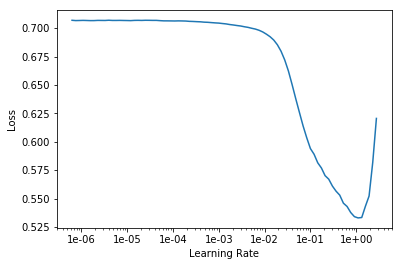

In [18]:
tcl.recorder.plot()

In [13]:
from torch.cuda import empty_cache
empty_cache()

In [13]:
tcl.fit_one_cycle(3, max_lr=.1)

epoch,train_loss,valid_loss,time
0,0.131534,0.127683,10:48
1,0.117968,0.135518,13:55
2,0.107607,0.134197,11:01


Manual Learning Rate Annealing

In [16]:
tcl.fit(epochs=1, lr=slice(.0004))

epoch,train_loss,valid_loss,time
0,0.104590,0.118472,07:26


Unfreeze and keep training

In [17]:
tcl.freeze_to(-2)

In [20]:
tcl.fit(epochs=1, lr=slice(.0001))

epoch,train_loss,valid_loss,time
0,0.102634,0.129381,08:30


In [21]:
tcl.fit(epochs=1, lr=slice(.0004))

epoch,train_loss,valid_loss,time
0,0.103204,0.107321,08:09


In [25]:
classifier_model_path = tcl.save(file='classifier_best_model',
                                 return_path=True)

In [26]:
classifier_model_path

PosixPath('/ds/multi_class_model/models/classifier_best_model.pth')

# Measure Performance on Validation Set

In [55]:
val_preds = tcl.get_preds()

In [61]:
val_preds2 = val_df.text.apply(lambda x: tcl.predict(x)[2].cpu().numpy())

In [73]:
val_preds2_matrix = np.stack(val_preds2.values)

In [32]:
val_proba = val_preds[0].cpu().numpy()
val_proba.shape

(3910, 45)

In [54]:
val_df.head()

,text,labels
9849,xxxfldtitle networking should function for intra-pod communication conformance xxxjson xxxfldbody https: xxxfilepath xxxlnkhb k8s-gubernator.appspot.com xxxlnkhe failed: networking should function for intra-pod communication conformance xxxjson xxxfilepath expected error: < errors.errorstring | 0xcxxunkd10>: xxxjson gave up waiting for pod 'nettest-dx1d3' to be 'running' after 5m0s not to have occurred,kind/flake
14320,"xxxfldtitle enable log rotate for container xxxfldbody \ r \ r is this a bug report or feature request? : \ r \ r > uncomment only one, leave it on its own line: \ r > \ r > \ r \ r what happened : \ r the logs in container cannot be rotated, docker already support this, it is better add this feature to kubernetes. \ r \ r \ r $ docker run -it --log-opt max-size=10m --log-opt max-file=3 busybox xxxfilepath -c 'i=0; while true; do echo \ $i: $ date \ ; i=$ i+1 ; sleep 0.001; done' \ r \ r \ r more detail refer to: \ r \ r https: xxxfilepath xxxlnkhb docs.docker.com xxxlnkhe \ r what you expected to happen : \ r \ r how to reproduce it as minimally and precisely as possible : \ r \ r \ r anything else we need to know? : \ r \ r environment : \ r - kubernetes version use kubectl version : \ r - cloud provider or hardware configuration : \ r - os e.g. from xxxfilepath : \ r - kernel e.g. uname -a : \ r - install tools: \ r - others: \ r",kind/feature sig/apps
6680,xxxfldtitle kubernetes audit log not generated xxxfldbody xxxqb \ r xxxfilepath remains empty even with new pods / deployments generated. \ r \ r i've setup my own cluster in two vms using kubeadm with the following config: \ r \ r \ r apiversion: kubeadm.k8s.io / v1alpha2 \ r api: \ r advertiseaddress: xxunk \ r bindport: 6443 \ r networking: \ r podsubnet: \ xxunk / 16 \ \ r auditpolicy: \ r logdir: xxxfilepath logmaxage: 2 \ r path: \ \ \ r \ r \ r xxxfilepath exists and has 777 permissions. \ r \ r \ r \ r kubectl version \ r client version: version.info xxxjson \ r the connection to the server localhost:8080 was refused - did you specify the right host or port? \ r \n xxxqe,needs-sig
9714,"xxxfldtitle unset kube_user causes startup to fail in gce scripts xxxfldbody the gce scripts assume that the basic-auth authenticator will always be enabled, so they assume that kube_user and kube_password will be set.",needs-sig
3277,"xxxfldtitle kubeadm fails to generate self-signed signature xxxfldbody xxunk \ r having trouble getting kubeadm to work properly for my raspberry pi cluster, i'm seeing: \ r \ r \ r root@node-1: xxxfilepath kubeadm join xxunk xxunk \ r running pre-flight checks \ r xxxhtml validating provided token \ r xxxhtml created cluster info discovery client, requesting info from \ http: xxxfilepath xxxlnkhb xxunk xxxlnkhe \ r xxxhtml cluster info object received, verifying signature using given token \ r xxxhtml cluster info signature and contents are valid, will use api endpoints https: / / xxunk:6443 xxxlnkhb xxunk xxxlnkhe \ r xxxhtml trying to connect to endpoint https: / / xxunk:6443 \ r xxxhtml detected server version v1.4.4 \ r xxxhtml successfully established connection with endpoint https: / / xxunk:6443 \ r xxxhtml created api client to obtain unique certificate for this node, generating keys and certificate signing request \ r \ r kubeadm: i am an alpha version, my authors welcome...",sig/auth


In [86]:
i = 10
idx = np.argmax(val_preds2_matrix[i, :])
print(f'{class_list[i]}')
print(f'ground truth: {val_df.iloc[idx]}')

lifecycle/rotten
ground truth: text      xxxfldtitle kubernetes audit log not generated xxxfldbody xxxqb \ r xxxfilepath remains empty even with new pods / deployments generated. \ r \ r i've setup my own cluster in two vms using kubeadm with the following config: \ r \ r \ r apiversion: kubeadm.k8s.io / v1alpha2 \ r api: \ r advertiseaddress: xxunk \ r bindport: 6443 \ r networking: \ r podsubnet: \ xxunk / 16 \ \ r auditpolicy: \ r logdir: xxxfilepath logmaxage: 2 \ r path: \ \ \ r \ r \ r xxxfilepath exists and has 777 permissions. \ r \ r \ r \ r kubectl version \ r client version: version.info xxxjson \ r the connection to the server localhost:8080 was refused - did you specify the right host or port? \ r \n xxxqe
labels                                                                                                                                                                                                                                                                         

In [87]:
class_list = tcl.data.classes
assert len(class_list) == val_proba.shape[1]

In [88]:
val_scores = {}
for i, lbl in enumerate(class_list):
    ground_truth = val_df.labels.apply(lambda x: lbl in x).values
    predicted_probs = val_preds2_matrix[:, i]
    val_scores[lbl] = {'yhat': predicted_probs, 'y': ground_truth}

In [89]:
from sklearn.metrics import roc_auc_score as auc

In [90]:
auc_scores = []
labels = []

for lbl in val_scores:
    auc_scores.append(auc(val_scores[lbl]['y'], val_scores[lbl]['yhat']))
    labels.append(lbl)

In [92]:
assert len(auc_scores) == len(labels)

In [93]:
score_df = pd.DataFrame({'label':labels, 'auc': auc_scores})
score_df

,label,auc
0,help,0.810217
1,kind/api-change,0.898669
2,kind/bug,0.903294
3,kind/cleanup,0.916457
4,kind/design,0.910580
5,kind/documentation,0.938305
6,kind/failing-test,0.953468
7,kind/feature,0.917767
8,kind/flake,0.989418
9,lifecycle/frozen,0.789269


In [94]:
score_df.to_pickle('score_df.pkl')

In [ ]:
score_df = pd.DataFrame({'label'f'] = pivot.apply(lambda x: abs(x.deep - x.baseline), axis=1)
pivot['label c: labels, 
                         'auc': auc_scores})

In [73]:
pivot = compare_df.pivot(index='label', columns='category', values='auc')
pivot['winner'] = pivot.apply(lambda x: 'deep' if x.deep > x.baseline else 'baseline', axis=1)
pivot['abs diff'] = pivot.apply(lambda x: abs(x.deep - x.baseline), axis=1)
pivot['label count'] = [c[x] for x in pivot.index.values]
pivot.sort_values(by=['label count'], ascending=False)

category,baseline,deep,winner,abs diff,label count
label,,,,,
sig/node,0.91357,0.91581,deep,0.00224,2738
sig/api-machinery,0.91833,0.92121,deep,0.00288,2228
sig/network,0.95846,0.96263,deep,0.00417,1829
sig/storage,0.97308,0.97626,deep,0.00318,1596
sig/cli,0.95712,0.95872,deep,0.00160,1109
sig/cluster-lifecycle,0.90756,0.90328,baseline,0.00428,950
sig/apps,0.93730,0.93157,baseline,0.00573,844
sig/scheduling,0.94497,0.94750,deep,0.00253,798
sig/testing,0.92759,0.92639,baseline,0.00120,715


## Notes: How To Do Model Inference

In [96]:
pred = tcl.predict(val_df.text.iloc[1])
pred

(MultiCategory kind/bug;sig/storage,
 tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 tensor([6.5999e-03, 1.4249e-03, 9.4289e-01, 1.4714e-02, 2.0936e-03, 4.2133e-04,
         3.5251e-03, 1.5203e-01, 5.5862e-04, 6.8666e-03, 3.3344e-01, 3.0993e-02,
         5.2516e-03, 4.0183e-03, 6.1540e-03, 4.1284e-02, 1.2610e-02, 5.7161e-02,
         3.4535e-02, 7.1595e-03, 1.6362e-03, 4.7670e-03, 6.8910e-04, 6.9218e-03,
         1.5391e-03, 7.6105e-03, 1.1268e-03, 7.3561e-03, 1.1026e-04, 3.1895e-04,
         1.1466e-02, 9.8176e-03, 1.7623e-04, 9.7702e-03, 2.4318e-01, 5.0895e-03,
         6.7916e-04, 5.8392e-03, 2.1515e-02, 8.9768e-01, 2.5650e-02, 4.0036e-03,
         6.3843e-04, 8.8857e-04, 6.6078e-03]))

In [97]:
val_df.labels.iloc[1]

'kind/bug sig/storage'

In [98]:
tcl.data.classes[torch.argmax(pred[1]).item()]

'sig/storage'

In [100]:
pred_proba = [(v,k) for k, v in zip(tcl.data.classes, pred[2].data.tolist())]
pred_proba.sort(reverse=True)
pred_proba

[(0.942894697189331, 'kind/bug'),
 (0.8976842761039734, 'sig/storage'),
 (0.3334384262561798, 'lifecycle/rotten'),
 (0.24317985773086548, 'sig/node'),
 (0.15203484892845154, 'kind/feature'),
 (0.05716130509972572, 'priority/important-soon'),
 (0.04128386080265045, 'priority/critical-urgent'),
 (0.034535009413957596, 'sig/api-machinery'),
 (0.03099348396062851, 'lifecycle/stale'),
 (0.02564980834722519, 'sig/testing'),
 (0.021514995023608208, 'sig/scheduling'),
 (0.014714262448251247, 'kind/cleanup'),
 (0.01260975282639265, 'priority/important-longterm'),
 (0.011466153897345066, 'sig/gcp'),
 (0.009817550890147686, 'sig/instrumentation'),
 (0.009770188480615616, 'sig/network'),
 (0.007610503118485212, 'sig/cli'),
 (0.007356122136116028, 'sig/cluster-lifecycle'),
 (0.007159530185163021, 'sig/apps'),
 (0.006921829655766487, 'sig/aws'),
 (0.006866577081382275, 'lifecycle/frozen'),
 (0.0066078477539122105, 'wanted'),
 (0.006599870976060629, 'help'),
 (0.006153956986963749, 'priority/backlog'